In [293]:
import json
import sys
import os
import numpy as np
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

def load_list (filepath):
    """
    Given a filepath of a textfile containing contiguous Twitter Tweet object (JSON format), unpack them into a list and
    return
    @:param filepath - string pointing to the textfile to be analyzed
    @:return list of JSON-formatted strings representing Tweet Objects
    """
    tweets = None
    with open(filepath, 'r') as file:
        tweets = []
        current_tweet = ""
        bracket_balance = 0
        while 1:
            current_char = file.read(1)
            if not current_char:
                break

            current_tweet = current_tweet + current_char

            if current_char == '{':
                bracket_balance += 1
            elif current_char == '}' and current_tweet[len(current_tweet) - 13:] != "Intelligence}" and \
                    current_tweet[len(current_tweet) - 10:] != "ufe0f(~);}":
                bracket_balance -= 1
                if bracket_balance == 0:
                    current_dict = json.loads(current_tweet)
                    tweets.append(current_dict)
                    current_tweet = ""
    return tweets


def build_features(tweets):
    """
    From a list of JSON-formatted strings representing Tweet objects, return a numpy array with tweets as rows and select
    features as columns
    @:param tweets - list of JSON-formatted strings representing Tweet objects
    @:return numpy numeric array with len(tweets) rows and columns corresponding to relevant features. Returns None if no
    valid tweets found
    """
    features = np.zeros((len(tweets), 12))
    nlp = spacy.load("en_core_web_sm")
    vds = SentimentIntensityAnalyzer()
    row = 0
    ids = []
    for i in range(len(tweets)):

        # Configure tweet to original/retweeted object if tweet is not retweeted or retweeted
        if 'retweeted_status' in tweets[i].keys():
            tweet = tweets[i]['retweeted_status']
        else:
            tweet = tweets[i]

        if tweet['id'] in ids:
            continue
        else:
            ids.append(tweet['id'])

        # Get full text
        if 'full_text' in tweet.keys():
            full_text = tweet['full_text']
        else:
            full_text = tweet['text']
        # loads text into spacy model
        doc = nlp(full_text)

        # Col 0 - Total char length, Col 1 - Average sentence length, Col 2 - word count
        features[row, 0] = len(full_text)
        sentences = list(doc.sents)
        features[row, 1] = sum([len(i) for i in sentences])
        words = [token.text for token in doc if not token.is_punct]
        features[row, 2] = len(words)

        # Col 3 - Number Hashtags used, Col 4 - Number User Mentions, Col 5 - Number URL's
        features[row, 3] = len(tweet['entities']['hashtags'])
        features[row, 4] = len(tweet['entities']['user_mentions'])
        features[row, 5] = len(tweet['entities']['urls'])

        # Date dictionary conversion
        dates = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5, 'sat': 6, 'sun': 7}
        # Isolate time and verify proper notation
        time = tweet['created_at'][11:16]
        if time[2] != ':':
            print("Time Notational Error")
            sys.exit()
        time = int(time[0:2]) * 60 + int(time[4:])

        # Col 6 - Day, Col 7 - Time
        features[row, 6] = dates[tweet['created_at'][0:3].lower()]
        features[row, 7] = time

        # Col 8 - Sentiment. In some cases, either VADER or TextBlob result in scores of 0 - I consider this an error
        vdsAnalysis = vds.polarity_scores(full_text)['compound']
        blobAnalysis = TextBlob(full_text).sentiment.polarity
        if vdsAnalysis == 0:
            features[row, 8] = blobAnalysis
        else:
            features[row, 8] = vdsAnalysis

        # Col 9 - Likes (favorites) of the Tweet, Col 10 - Retweets
        features[row, 9] = tweets[i]['user']['followers_count']
        features[row, 10] = tweet['favorite_count']
        features[row, 11] = tweet['retweet_count']
        row += 1
    if not features.any():
        return None
    return features[~np.all(features == 0, axis=1)]


def build_dataset(source):
    """
    Given a directory, load every text file and utilize load_list as well as build_features to assemble a database
    @:param source - directory to load Tweet record files from
    @:return numpy array of all selected Tweet instances and associated features
    """
    dataset = None
    # Iterate through all files in the directory
    for file in os.listdir(source):
        # Load the tweets in file and build features
        tweet_list = load_list(source + "/" + file)
        current_features = build_features(tweet_list)
        # Continue if no features found and add to dataset otherwise
        if current_features is None:
            continue
        if dataset is None:
            dataset = current_features
        else:
            dataset = np.vstack((dataset, current_features))
    return dataset


In [294]:
# Builds and merges datasets from both collections of Tweets
dataset1= build_dataset("data/Permanent")
dataset2 = build_dataset("data/Crises")
dataset = np.vstack((dataset1, dataset2))

# Creates a correlation matrix of all features in the dataset created above
corr = np.corrcoef(dataset, rowvar=False)
print(dataset.shape)




(7241, 12)


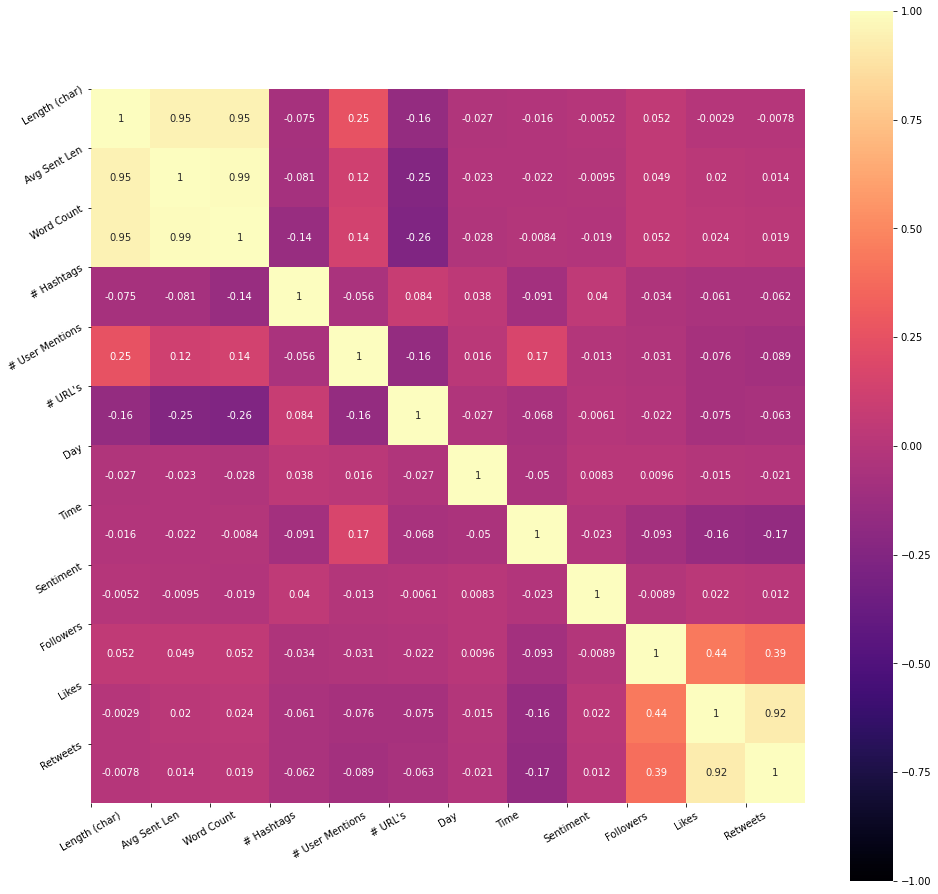

In [295]:
# Creates a heatmap of the previous correlation matrix
plt.figure(figsize=(16, 16))
labels = ['Length (char)','Avg Sent Len', 'Word Count', '# Hashtags', '# User Mentions', '# URL\'s', 'Day', 'Time', 'Sentiment',
          'Followers', 'Likes', 'Retweets']
ax = sns.heatmap(corr, annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, square=True, cmap='magma')
ax.set_xticks([i for i in range(12)])
ax.set_yticks([i for i in range(12)])
ax.set_xticklabels(labels, rotation=30)
ax.set_yticklabels(labels, rotation=30)
ax.tick_params(axis='both', which='both', labelsize=10, labelbottom = True, left=True, bottom=True, top = False, labeltop=False)
fig = ax.get_figure()
fig.savefig("Covariance_Matrix.png", dpi=400)

Text(0.5, 1.0, 'Number of Tweets vs Likes per Tweet (Permanent Data)')

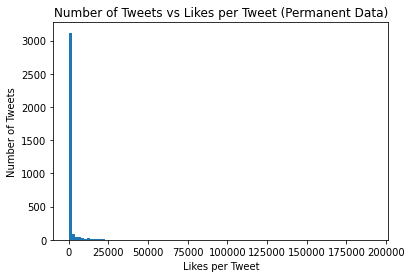

In [296]:
# Creats a Histogram of all tweets and likes per tweet for Permanent Data Dataset
plt.hist(dataset1[:, 11], bins=100)
plt.xlabel("Likes per Tweet")
plt.ylabel("Number of Tweets")
plt.title("Number of Tweets vs Likes per Tweet (Permanent Data)")

[2972.0 222.0 154.0 61.0 73.0 44.0 34.0 24.0 12.0 14.0 10.0 12.0 14.0 3.0
 8.0 6.0 8.0 4.0 5.0 4.0 3.0 3.0 1.0 8.0 2.0 5.0 1.0 3.0 4.0 3.0 2.0 5.0
 2.0 1.0 0.0 1.0 2.0 1.0 0.0 2.0 0.0 0.0 0.0 0.0 1.0 0.0 4.0 0.0 1.0 0.0
 2.0 0.0 0.0 0.0 5.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 2.0 0.0
 1.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 2.0]


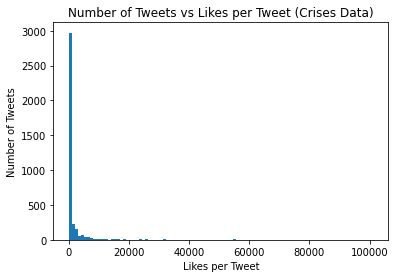

In [297]:
# Creats a Histogram of all tweets and likes per tweet for Crises Data Dataset
counts, edges, plot = plt.hist(dataset2[:, 11], bins=100)
plt.xlabel("Likes per Tweet")
plt.ylabel("Number of Tweets")
plt.title("Number of Tweets vs Likes per Tweet (Crises Data)")
np.set_printoptions(formatter={'all':lambda x: str(x)})
print(counts)


Text(0.5, 1.0, 'Number of Tweets vs Likes per Tweet (Crises Data)')

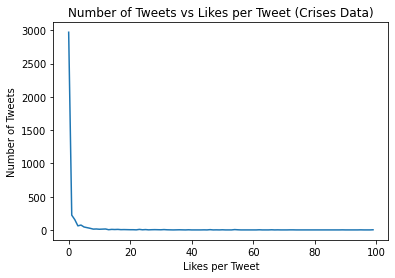

In [298]:
# Creats a Line Plot of all tweets and likes per tweet for Crises Data Dataset
np.set_printoptions(formatter=None)
plt.plot([i for i in range(len(counts))], counts)
plt.xlabel("Likes per Tweet")
plt.ylabel("Number of Tweets")
plt.title("Number of Tweets vs Likes per Tweet (Crises Data)")

(array([6.294e+03, 3.190e+02, 1.600e+02, 1.050e+02, 5.400e+01, 3.700e+01,
        4.500e+01, 2.100e+01, 3.300e+01, 1.400e+01, 1.800e+01, 1.200e+01,
        1.300e+01, 9.000e+00, 9.000e+00, 7.000e+00, 7.000e+00, 5.000e+00,
        5.000e+00, 5.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        4.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 5.000e+00, 3.000e+00,
        3.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 4.000e+00,
        3.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 6.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

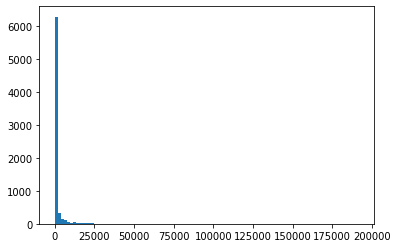

In [299]:
# Creats a Histogram of all tweets and likes per tweet for Both Datasets
plt.hist(dataset[:, 11], bins=100)

In [300]:
# Plots Feature importance from a Random Forest Classifier
def plot_feature_importance(random_forest):
    """
    -Display a bar plot showing the feature importance of every feature in 
     the random forest
    """
    labels = ['Length (char)','Avg Sent Len', 'Word Count', '# Hashtags', '# User Mentions', '# URL\'s', 'Day', 'Time', 'Sentiment',
          'Followers', 'Likes', 'Retweets']
    feature_importance = random_forest.feature_importances_
    indices = np.argsort(feature_importance)
    xlist = [i for i in range(len(feature_importance))]
    plt.bar(xlist, feature_importance[indices], color='red')
    plt.xlabel('Features')
    plt.ylabel('Feature Importance')
    plt.title('Feature Importance for predicting Popular Tweets')
    plt.xticks(xlist, [labels[i] for i in xlist], rotation='vertical')
    plt.show()

0.8321369409166206
2200


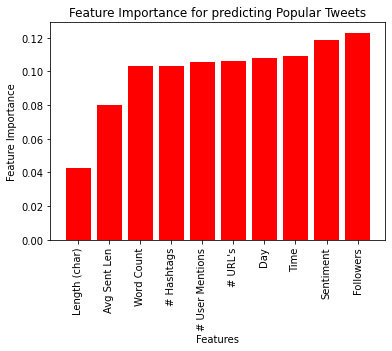

In [301]:
from sklearn.ensemble import RandomForestClassifier
max_score = 0
threshold = 0
max_forest = 0
# Determines the threshold of likes consituting the 80th percentile of both datasets and performs Random Forest Classification for all data fractions up to this point
for i in range(100, 10000, 100):
    # Breaks when 80th percentile is reached
    if np.count_nonzero(dataset[:, 10:11] > i) / dataset.shape[0] < .2:
        break
    
    # Divides Proportion of dataset based on current threshold
    classifcation_set = np.hstack((dataset, dataset[:, 10:11] > i))
    
    # Break into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(classifcation_set[:,0:10], classifcation_set[:, 12:13], random_state=1, shuffle=True)
    
    # Normalize data with respect to training set
    norm = Normalizer()
    norm.fit(X_train)
    X_train = norm.transform(X_train)
    X_test = norm.transform(X_test)
    
    # Perform Random Forest Classification
    forest = RandomForestClassifier(random_state=1)
    forest.fit(X_train, y_train.ravel())
    forest_pred = forest.predict(X_test)
    
    # Record accuracy score of classification
    score = forest.score(X_test, y_test)
    
    # Record score, model, and threshold if maximum accuracy reached
    if max_score < score:
        max_score = score
        threshold = i
        max_forest = forest
print(max_score)
print(threshold)
plot_feature_importance(max_forest)

In [302]:
from sklearn.svm import SVC
# Perform Support Vector Machine Classification

# Split data based on threshold
classifcation_set = np.hstack((dataset, dataset[:, 10:11] > 2200))

# Split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(classifcation_set[:,0:9], classifcation_set[:, 12:13], random_state=1, shuffle=True)

# Normalize data with respect to training set
norm = Normalizer()
norm.fit(X_train)
X_train = norm.transform(X_train)
X_test = norm.transform(X_test)

# Build Support Vector Machine Classifier
svm = SVC(random_state=1)
svm.fit(X_train, y_train.ravel())
svm_pred = svm.predict(X_test)

# Save accuracy score
score = svm.score(X_test, y_test)
print(score)

0.7835450027609056


In [303]:
from sklearn.neighbors import KNeighborsClassifier
# Perform K-Nearest Neighbors Classifier

# Split data based on threshold
classifcation_set = np.hstack((dataset, dataset[:, 10:11] > 2200))

# Split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(classifcation_set[:,0:10], classifcation_set[:, 12:13], random_state=1, shuffle=True)

# Normalize data with respect to training set
norm = Normalizer()
norm.fit(X_train)
X_train = norm.transform(X_train)
X_test = norm.transform(X_test)

# Build K-Nearest Neighbors Classifer
knearest = KNeighborsClassifier()
knearest.fit(X_train, y_train.ravel())
k_pred = knearest.predict(X_test)

# Save accuracy score
score = knearest.score(X_test, y_test)
print(score)

0.7719491993373827


## Sources of Influential Tweets

In [304]:
# This section reads crisis_analysis.txt and converts it into a list
import ast
# Maps each entry (of 10 maximum) to a label (e.g 0 popularity and 0 support is labelled 1)
sourceDict = {(0, 0): 1, (0, 1): 2, (1, 0): 3, (1, 1): 4}
# Crisis analysis will be a list of lists. Each list corresponds to a file and contains a filename and labels of top ten tweets
crisis_analysis = []
# crisis_analysis.txt is formatted with one entry per line, comma separated. Each entry has a file name and the identities of the top ten tweets (support, popularity)
with open("crisis_analysis.txt", 'r') as crisis:
    while True: 
        # Reads current entry
        currentVal = [0, 0]
        line = crisis.readline()
        if not line: 
            break
        # Gets filename
        currentVal[0] = line[0:line.index(",")]
        # Gets list of top ten tweet identities
        currentVal[1] = ast.literal_eval(line[line.index(",") + 2:])
        for i in range(len(currentVal[1])):
            # Converts identities to labels
            currentVal[1][i] = sourceDict[currentVal[1][i]]
        # Adds labelled top ten tweets and filename to crisis_analysis
        crisis_analysis.append(currentVal)
        

[483, 487, 2, 126]


Text(0.5, 1.0, 'Tweet Sources and Their Frequency')

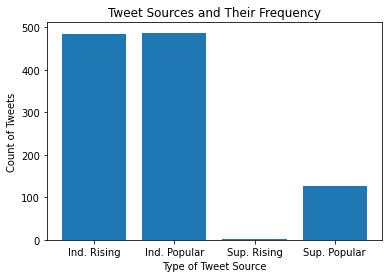

In [305]:
# This section counts all tweets from crisis_analysis and visualizes the distribution by label
counts = [0, 0, 0, 0]
labels = ["Ind. Rising", "Ind. Popular", "Sup. Rising", "Sup. Popular"]
# Increments through crisis_analysis and tallies tweets of each type
for i in crisis_analysis:
    for j in i[1]:
        counts[j - 1] += 1;
print(counts)
plt.bar(labels, counts)
plt.xlabel("Type of Tweet Source")
plt.ylabel("Count of Tweets")
plt.title("Tweet Sources and Their Frequency")

In [306]:
# This section copies crisis_analysis and counts the tweets of each identity as well as merging by topic
# Copy of crisis_analysis
rolling_crisis = crisis_analysis[:]
# Truncate filenames to ignore days
for i in rolling_crisis:
    i[0] = i[0][0:i[0].index('_')]
# Iterates through rolling_crisis and converts each topic's day's tweet identity list to a list of total tweets per identity
for i in rolling_crisis:
    # Placeholder for counts for each file - 
    inner_counts = [0, 0, 0, 0]
    # Adds to respective count
    for j in i[1]:
        inner_counts[j - 1] += 1;
    #Replaces identity list with counts
    i[1] = inner_counts
# This block merges all top ten tweets per day chronologically by topic
rolling_dict = {}
for i in rolling_crisis:
    # If topic is not in rolling_dict, add it (Day 0)
    if i[0] not in rolling_dict:
        rolling_dict[i[0]] = [i[1]]
    # If topic exists, append to it (Day 1-6)
    else:
        rolling_dict[i[0]].append(i[1])

In [307]:
# Visualize one topic from the dictionary
print(rolling_dict['Exxon'])

[[10, 0, 0, 0], [7, 1, 0, 2], [6, 2, 0, 0], [5, 2, 0, 0], [3, 7, 0, 0], [1, 6, 0, 3], [1, 5, 0, 4]]


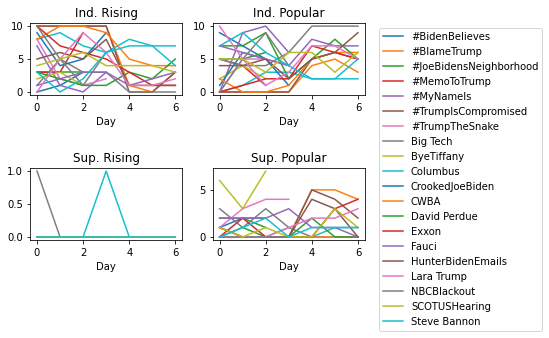

In [308]:
# This section plots all 7-day counts per topic. It divides each respective identity into its own graph
# Put every day's counts sequentially by topic in rolling_dict
fig, axs = plt.subplots(2, 2)
# Iterates through all identities
for i in range(0, 2):
    for j in range(0, 2):
        axs[i, j].set_title(labels[2 * i + j])
        axs[i, j].set_xlabel('Day')
        # Iterates through topics
        for k in list(rolling_dict.keys()):
            plot_points = []
            # Append the relevant count (of the correct identity) to points to plot
            for l in rolling_dict[k]:
                plot_points.append(l[2 * i + j])
            # Plot counts with their day as x-axis values
            axs[i, j].plot([m for m in range(len(plot_points))], plot_points, label=k)
plt.subplots_adjust(hspace=1)
plt.legend(bbox_to_anchor=(2.2,3))

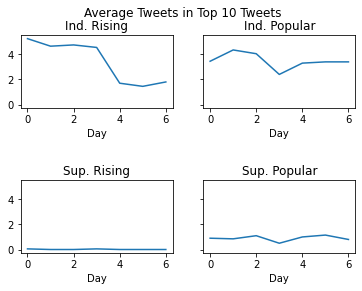

In [309]:
# Replicates previous section for average counts over all topics
fig, axs = plt.subplots(2, 2, sharey='all')
fig.suptitle("Average Tweets in Top 10 Tweets")
for i in range(0, 2):
    for j in range(0, 2):
        axs[i, j].set_title(labels[2 * i + j])
        axs[i, j].set_xlabel('Day')
        topic_averages = [0] * 7
        for k in list(rolling_dict.keys()):
            for average_point in range(len(rolling_dict[k])):
                topic_averages[average_point] += rolling_dict[k][average_point][2 * i + j]
        for k in range(len(topic_averages)):
            topic_averages[k] /= 20
        axs[i, j].plot([m for m in range(len(topic_averages))], topic_averages)
plt.subplots_adjust(hspace=1)

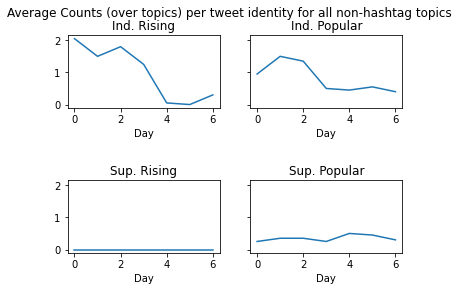

In [310]:
# Replicates previous section for average counts over all topics
fig, axs = plt.subplots(2, 2, sharey='all')
fig.suptitle("Average Counts (over topics) per tweet identity for all non-hashtag topics")
for i in range(0, 2):
    for j in range(0, 2):
        axs[i, j].set_title(labels[2 * i + j])
        axs[i, j].set_xlabel('Day')
        topic_averages = [0] * 7
        for k in list(rolling_dict.keys()):
            if k.find('#') == -1:
                continue
            for average_point in range(len(rolling_dict[k])):
                topic_averages[average_point] += rolling_dict[k][average_point][2 * i + j]
        for k in range(len(topic_averages)):
            topic_averages[k] /= 20
        axs[i, j].plot([m for m in range(len(topic_averages))], topic_averages)
plt.subplots_adjust(hspace=1)

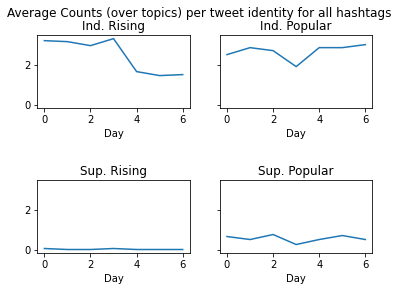

In [311]:
# Replicates previous section for average counts over all topics
fig, axs = plt.subplots(2, 2, sharey='all')
plt.suptitle("Average Counts (over topics) per tweet identity for all hashtags")
for i in range(0, 2):
    for j in range(0, 2):
        axs[i, j].set_title(labels[2 * i + j])
        axs[i, j].set_xlabel('Day')
        topic_averages = [0] * 7
        for k in list(rolling_dict.keys()):
            if k.find('#') != -1:
                continue
            for average_point in range(len(rolling_dict[k])):
                topic_averages[average_point] += rolling_dict[k][average_point][2 * i + j]
        for k in range(len(topic_averages)):
            topic_averages[k] /= 20
        axs[i, j].plot([m for m in range(len(topic_averages))], topic_averages)
plt.subplots_adjust(hspace=1)